  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

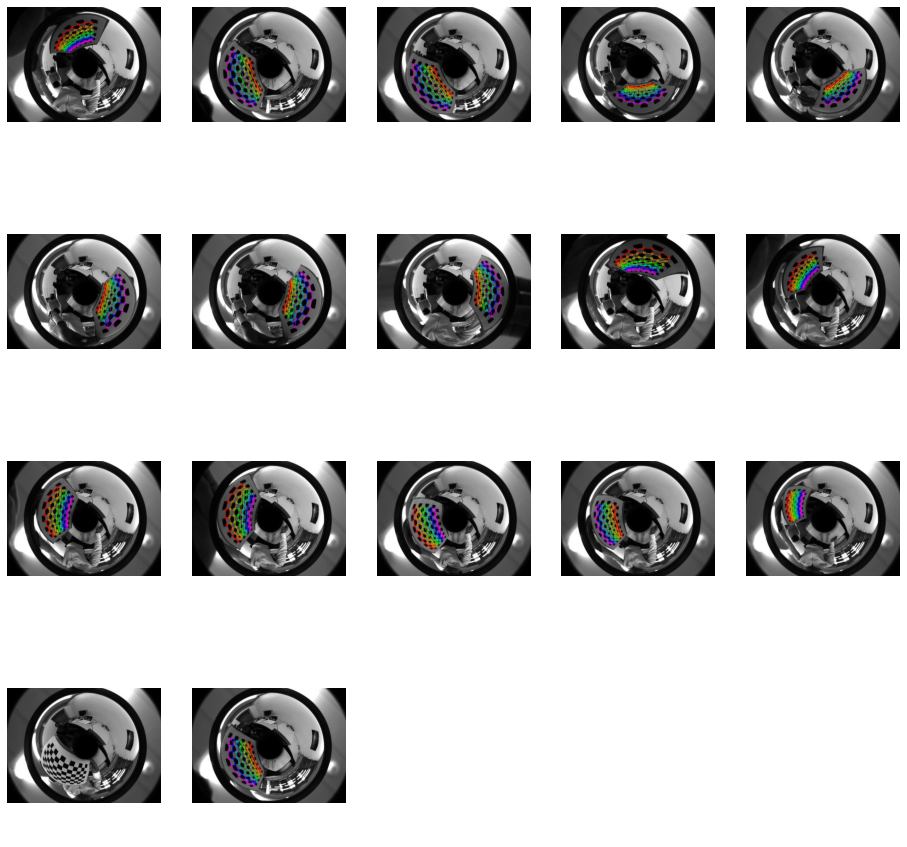

In [4]:
import math
from itertools import product
from pathlib import Path

import cv2 as cv
import torch
from matplotlib import pyplot as plt
from omnicalib.chessboard import get_points
from tqdm.notebook import tqdm

pattern_rows = 7
pattern_cols = 11

image_paths = sorted(Path('../example').iterdir())
object_points = get_points(pattern_rows, pattern_cols, 30.).view(-1, 3)
detections = {}

num_plots = len(image_paths)
cols = int(math.ceil(math.sqrt(num_plots)))
rows = int(math.ceil(num_plots / cols))
fig, ax = plt.subplots(rows, cols, squeeze=False, figsize=(16, 16))
ax = ax.flatten()
for a in ax:
    a.axis('off')

for idx, p in enumerate(tqdm(image_paths)):
    img = cv.imread(str(p), cv.IMREAD_GRAYSCALE)
    for block, bias in tqdm(list(product(
            range(20, 40, 5),
            range(-10, 31, 5)
    )), leave=False):
        block = (block // 2) * 2 + 1
        img_bw = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                                      cv.THRESH_BINARY, block, bias)
        ret, corners = cv.findChessboardCornersSB(
            img_bw, (pattern_cols, pattern_rows), flags=cv.CALIB_CB_EXHAUSTIVE)
        if not ret:
            ret, corners = cv.findChessboardCorners(
                img_bw, (pattern_cols, pattern_rows), flags=0)
        if ret:
            win_size = (5, 5)
            zero_zone = (-1, -1)
            criteria = (
                cv.TERM_CRITERIA_EPS + cv.TermCriteria_COUNT,
                40,
                0.001
            )
            cv.cornerSubPix(img, corners, win_size, zero_zone, criteria)
            detections[p] = {
                'image_points':
                torch.from_numpy(corners).to(torch.float64).squeeze(1),
                'object_points': object_points
            }
            break
    img = cv.drawChessboardCorners(cv.cvtColor(
        img, cv.COLOR_GRAY2BGR), (pattern_cols, pattern_rows), corners, ret)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ax[idx].imshow(img)
plt.show()

INFO:calibrate:Brute-force search for principal point (3 images with mean reprojection error <= 10.0)
inf   +0   +0:   0%|                                                                                                                                                                                                                                              | 0/397 [00:00<?, ?it/s]
INFO:calibrate:Valid solution for 5/16 images
INFO:calibrate:Initial reprojection error $\mu=1.6, \sigma=6.1\mathrm{e}{-1}$
INFO:calibrate:Initial principal point (319.5, 239.5)
INFO:calibrate:Initial solution for 5/5 valid


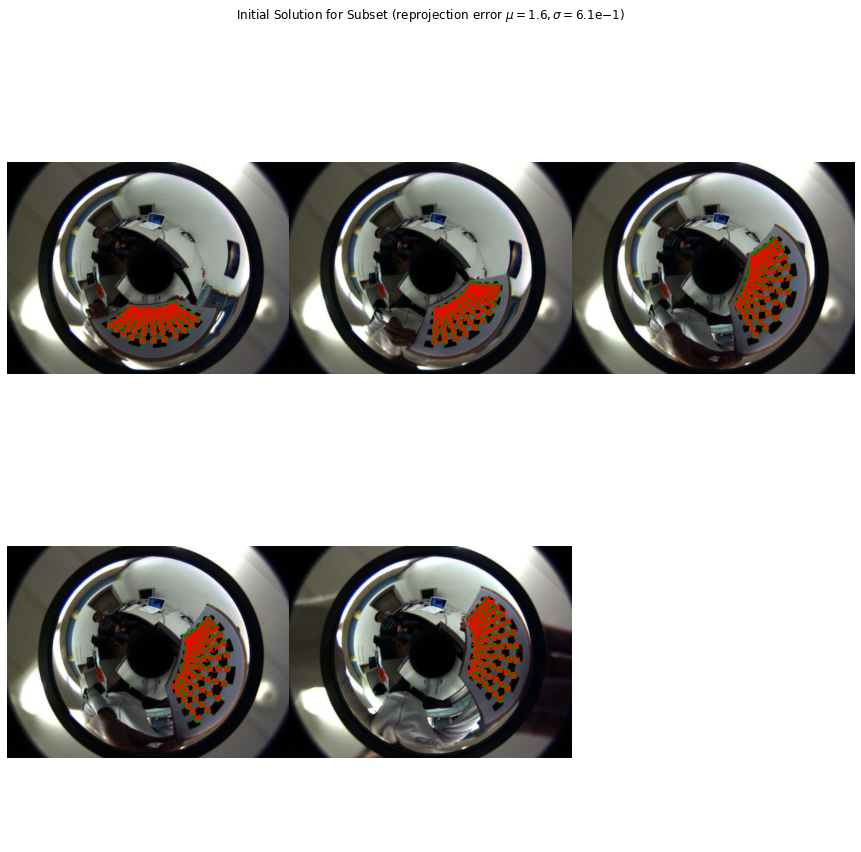

rmse 4.711e-01: : 21it [00:05,  4.13it/s]
INFO:calibrate:Optimized reprojection error $\mu=4.1\mathrm{e}{-1}, \sigma=5.3\mathrm{e}{-1}$
INFO:calibrate:Optimized principal point (323.8, 248.7)


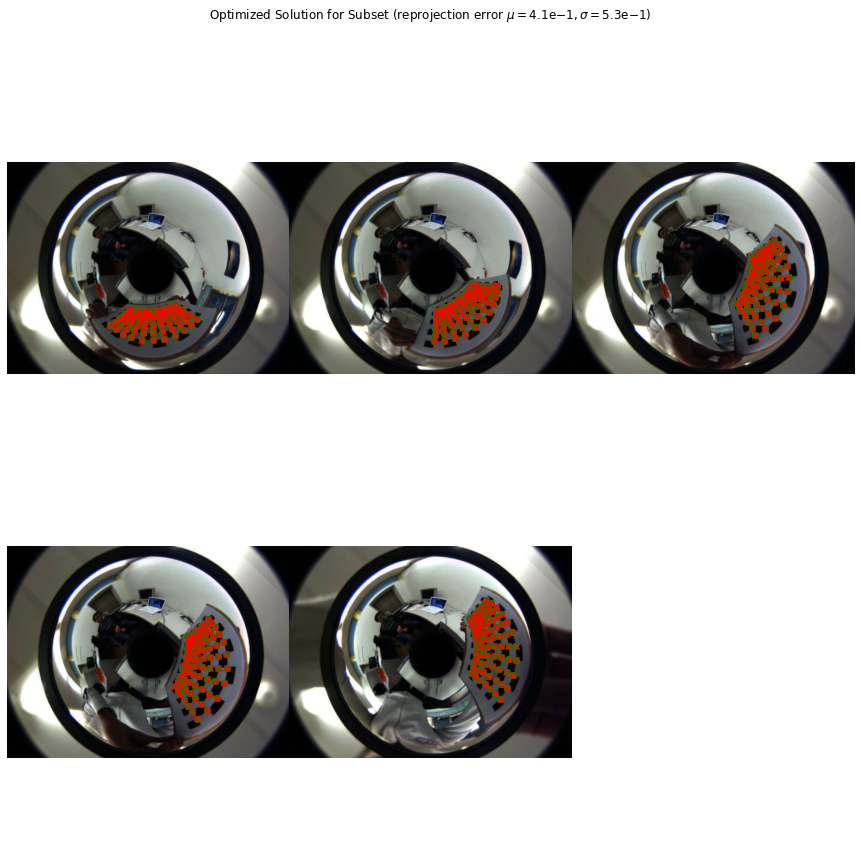

rmse 3.540e-01: : 15it [00:18,  1.24s/it]
INFO:calibrate:Final reprojection error $\mu=3.3\mathrm{e}{-1}, \sigma=3.8\mathrm{e}{-1}$
INFO:calibrate:Final principal point (324.5, 247.7)


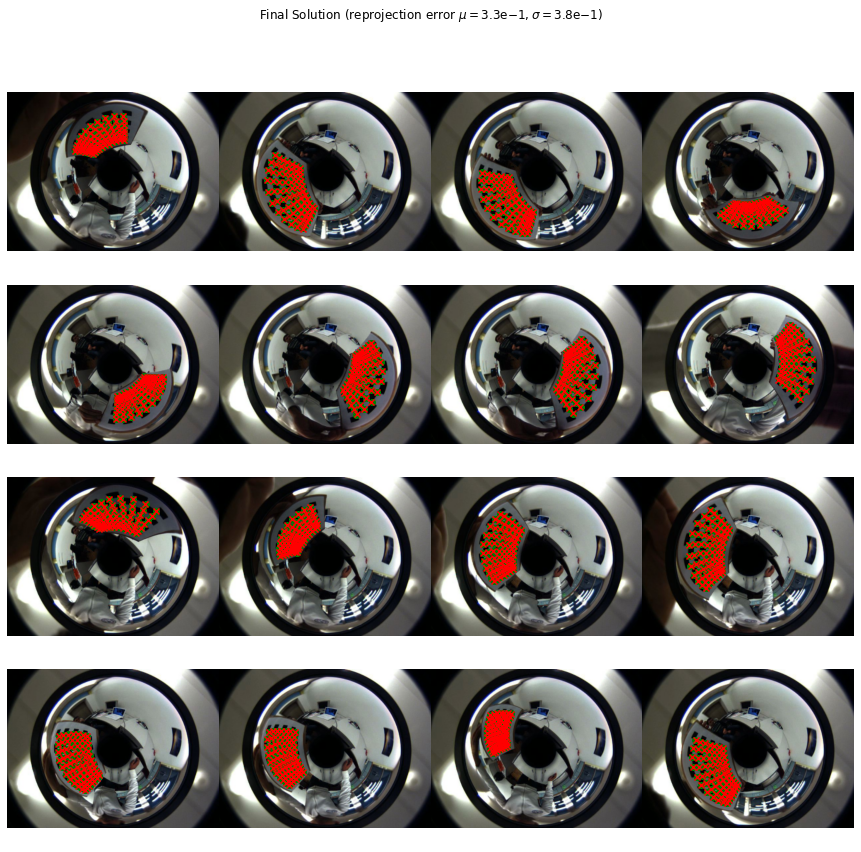

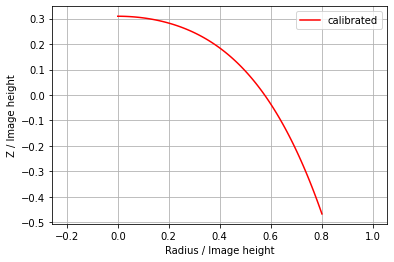

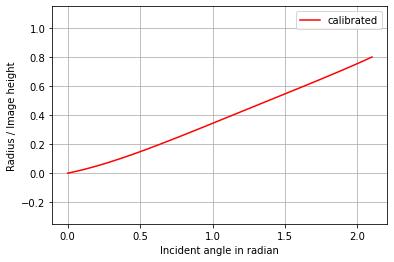

In [5]:
from omnicalib import main
main(detections, 4, 10, 3)